In [1]:
from string import punctuation
import os
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# update counts
	vocab.update(tokens)

# load all docs in a directory
def process_docs_1(directory, vocab):
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip files that do not have the right extension
		if not filename.endswith(".txt"):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# add doc to vocab
		add_doc_to_vocab(path, vocab)
# load all docs in a directory
def process_docs_2(directory, vocab):
	lines = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip files that do not have the right extension
		if not filename.endswith(".txt"):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load and clean the doc
		line = doc_to_line(path, vocab)
		# add to list
		lines.append(line)
	return lines
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
	# load the doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)


# save list to file
def save_list(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()


# load vocabulary
vocab_filename = 'aclImdb/imdb.vocab'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
positive_docs = process_docs_2('aclImdb/train/pos', vocab)
negative_docs = process_docs_2('aclImdb/train/neg', vocab)
train_docs = negative_docs + positive_docs
print(len(vocab))
print(len(positive_docs))
print(len(train_docs))

89527
12500
25000


In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers.pooling import MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.layers.convolutional import Conv1D
from keras.utils.vis_utils import plot_model
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#logo tou provlhmatos me to cudnn
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# training
epochs = 10
# Convolution
kernel_size = 5
filters = 64
pool_size = 4
# vector
n_dim = 300 
n_unique_words = 20000
max_review_length = 200
pad_type = trunc_type = 'pre'
# LSTM
n_lstm = 128 
drop_lstm = 0.2

# create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)
print(len(encoded_docs))

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

25000


In [3]:
x_train = pad_sequences(encoded_docs, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [4]:
print(len(x_train))

25000


In [5]:
y_train = np.array([0 for _ in range(12500)] + [1 for _ in range(12500)])
print(len(y_train))

25000


In [6]:
# load all test reviews
positive_docs = process_docs_2('aclImdb/test/pos', vocab)
negative_docs = process_docs_2('aclImdb/test/neg', vocab)
test_docs = negative_docs + positive_docs
encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_valid = pad_sequences(encoded_docs, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
y_valid = np.array([0 for _ in range(12500)] + [1 for _ in range(12500)])
print(len(x_valid))
print(len(y_valid))

25000
25000


In [7]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Dropout(0.25))
#model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
model.summary()
#plot_model(model, show_shapes=True, to_file='pre_cnnlstm.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,195,009
Trainable params: 6,195,009
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# checkpoint
output_dir = "model_weights/trainable_emb_cnnlstm"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
filepath=output_dir+"/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
history = model.fit(x_train, y_train, epochs=epochs, callbacks=callbacks_list, verbose=1, validation_data=(x_valid, y_valid))



Train on 25000 samples, validate on 25000 samples
Epoch 1/10




25000/25000 [==============================] - 69s 3ms/step - loss: 0.3535 - acc: 0.8436 - val_loss: 0.2928 - val_acc: 0.8797

Epoch 00001: val_acc improved from -inf to 0.87968, saving model to model_weights/trainable_emb_cnnlstm/weights-improvement-01-0.88.hdf5
Epoch 2/10
25000/25000 [==============================] - 60s 2ms/step - loss: 0.1731 - acc: 0.9366 - val_loss: 0.3225 - val_acc: 0.8711

Epoch 00002: val_acc did not improve from 0.87968
Epoch 3/10
25000/25000 [==============================] - 66s 3ms/step - loss: 0.0805 - acc: 0.9720 - val_loss: 0.4516 - val_acc: 0.8632

Epoch 00003: val_acc did not improve from 0.87968
Epoch 4/10
25000/25000 [==============================] - 60s 2ms/step - loss: 0.0343 - acc: 0.9889 - val_loss: 0.5808 - val_acc: 0.8513

Epoch 00004: val_acc did not improve from 0.87968
Epoch 5/10
25000/25000 [==============================] - 60s 2ms/step - loss: 0.0205 - acc: 0.9936 - val

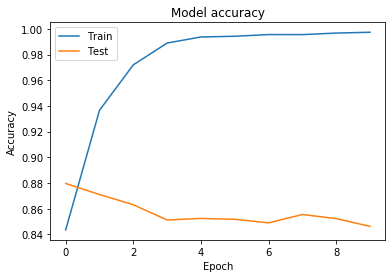

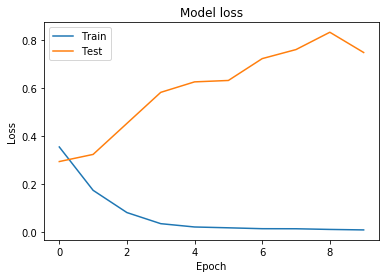

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
model.load_weights(output_dir+"/weights-improvement-01-0.88.hdf5")

In [15]:
y = model.predict_proba(x_valid)

(array([7255., 1668., 1111.,  869.,  840.,  791.,  816.,  996., 1668.,
        8986.]),
 array([0.00140107, 0.10095783, 0.20051458, 0.30007133, 0.3996281 ,
        0.49918485, 0.5987416 , 0.69829834, 0.79785514, 0.8974119 ,
        0.9969686 ], dtype=float32),
 <a list of 10 Patch objects>)

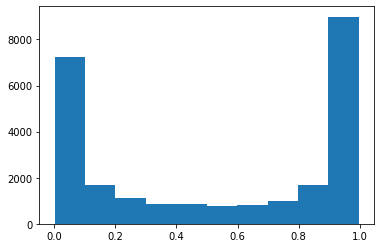

In [16]:
plt.hist(y)

In [17]:
score = model.evaluate(x_valid, y_valid, verbose=0)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 87.97%


In [18]:
#area under curve score
"{:0.2f}".format(roc_auc_score(y_valid, y)*100)

'94.98'